## Содержание:
* [Стационарность](#stacionary)
* [Преобразование Бокса-Кокса](#boxcox)
* [Модели для предсказания значений временного ряда](#predict)
* [Метрики точности прогноза](#metrics)

Импортируем библиотеки

In [105]:
# Импортируем необходимые библиотеки

import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

Рутина с датасетами

In [106]:
# аналогичным образом загружаем данные о пассажирах
passengers = pd.read_csv('Weekly demand for a plastic container Montgomery  Johnson.csv')
passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  100 non-null    int64
 1   x           100 non-null    int64
dtypes: int64(2)
memory usage: 1.7 KB


In [107]:
passengers.describe()

,Unnamed: 0,x
count,100.000000,100.000000
mean,50.500000,5985.160000
std,29.011492,782.603525
min,1.000000,4491.000000
25%,25.750000,5436.250000
50%,50.500000,6031.500000
75%,75.250000,6657.750000
max,100.000000,7411.000000


Отрисовываем временной ряд

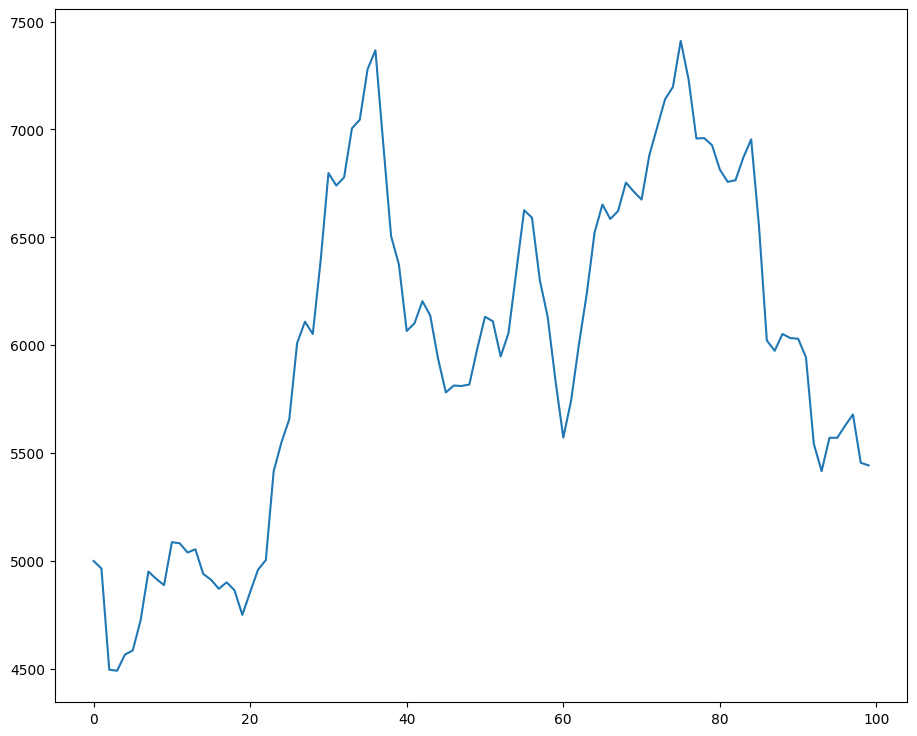

In [108]:
plt.plot(passengers["x"])

## Стационарный процесс  <a class="anchor" id="stacionary"></a>

Стационарный процесс - это случайный процесс, безусловное совместное распределение вероятностей которого не изменяется при сдвиге во времени. Следовательно, такие параметры, как среднее значение и дисперсия, также не меняются со временем, поэтому стационарные временные ряды легче прогнозировать.

Есть несколько способов установить, является ли временной ряд стационарным или нет, наиболее распространенными являются старая добрая визуализация, просмотр автокорреляции и выполнение статистических тестов.

Наиболее распространенным тестом является тест Дики-Фуллера (также называемый тест ADF), где нулевая гипотеза состоит в том, что временной ряд имеет единичный корень, другими словами, временной ряд не является стационарным.

Мы проверим, можно ли отвергнуть нулевую гипотезу, сравнив значение p с выбранным порогом (α), чтобы, если значение p меньше, мы могли отклонить нулевую гипотезу и предположить, что временной ряд с уверенностью является стационарным. уровень 1-α (технически мы просто не можем сказать, что это не так)

Временной ряд имеет единичный корень, или порядок интеграции один, если его первые разности образуют стационарный ряд. Это условие записывается как
$y_t\thicksim I(1)$ если ряд первых разностей $\triangle y_t=y_t-y_{t-1}$ является стационарным $\triangle y_t\thicksim I(0)$.

При помощи этого теста проверяют значение коэффициента $a$ в  авторегрессионном уравнении первого порядка AR(1)
$y_t=a\cdot y_{t-1}+\varepsilon_t,$
где $y_t$ — временной ряд, а $\varepsilon$— ошибка.

Если $a=1$, то процесс имеет единичный корень, в этом случае ряд $y_t$ не стационарен, является интегрированным временным рядом первого порядка $I(1)$. Если $|a|<1$, то ряд стационарный $I(0)$.


In [109]:
# импортируем функцию, описывающую тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

In [110]:
# всю теорию, описанную выше, реализуем с помощью statsmodels для проверки
# временного ряда перевозок на стационарность

alpha = 0.05
name = "Спрос"

# определяем временной ряд отдельной переменной
ts = df["x"]

print(f'Тест Дики-Фуллера ряда {name} :')
# определяем результат значения теста из библиотеки с учетом
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Спрос :
Test Statistic                 -2.545720
p-value                         0.104743
#Lags Used                      6.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


А теперь попробуем осуществить дифференцирование. Перед этим опять попробуем декомпозицию ряда.

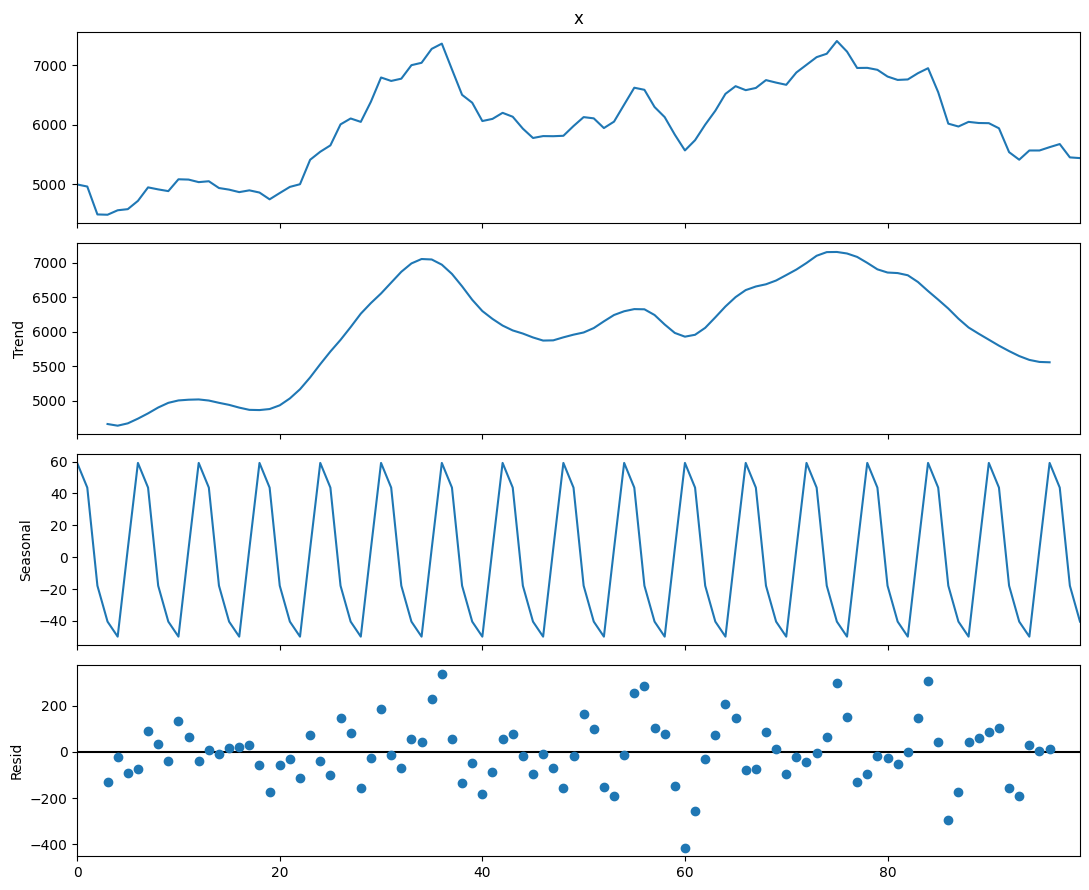

In [111]:
# импортируем функцию seasonal_decompose из statsmodels
# (то есть осуществляем декомпозицию сигнала/временного ряда)
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


# применяем функцию к данным о перевозках
decompose = seasonal_decompose(passengers["x"],
                               period=6)
decompose.plot()
plt.show()

Создадим два временных ряда на основе имеющегося, только без тренда и сезонности.

Удаляем тренд согласно формуле: $y' = y_t - y_{t-1}$;

Удаляем сезонность согласно формуле: $y' = y_t - y_{t-s}$;

In [112]:
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(1, len(df["x"])):
   nottrend.append(df["x"][i] - df["x"][i-1])

# выборка без сезонности
for i in range(s, len(df["x"])):
   notseason.append(df["x"][i] - df["x"][i-s])


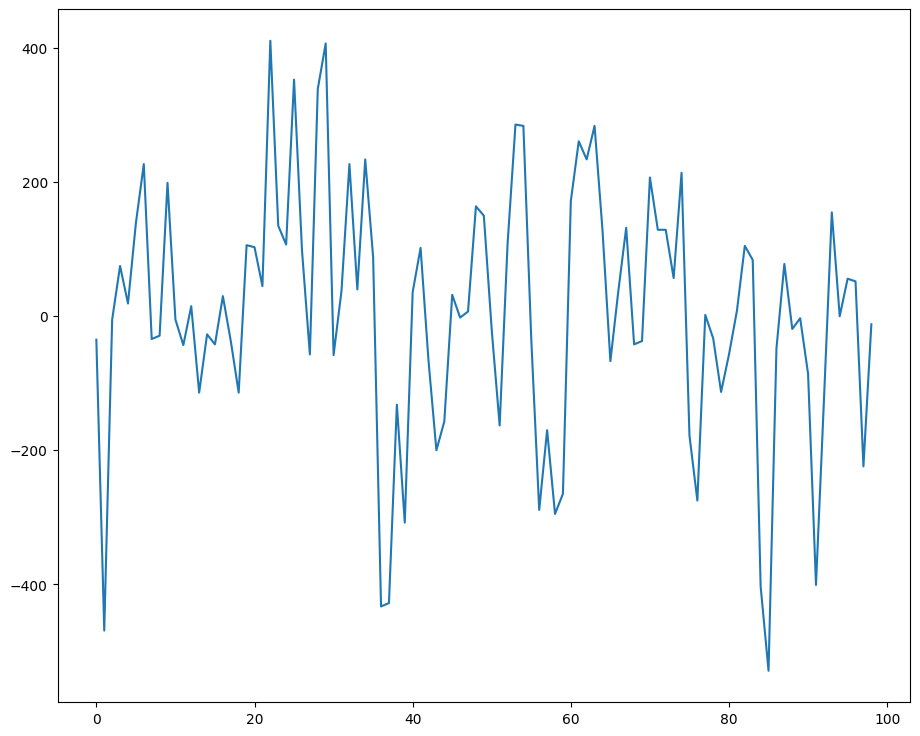

In [113]:
# отрисовываем временной ряд без тренда
plt.plot(nottrend)

Теперь проведем тест Дики-Фуллера на временном ряде без тренда

In [114]:
alpha = 0.05
name = "Cпрос без тренда"

ts = nottrend

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Cпрос без тренда :
Test Statistic                 -3.694814
p-value                         0.004187
#Lags Used                      4.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


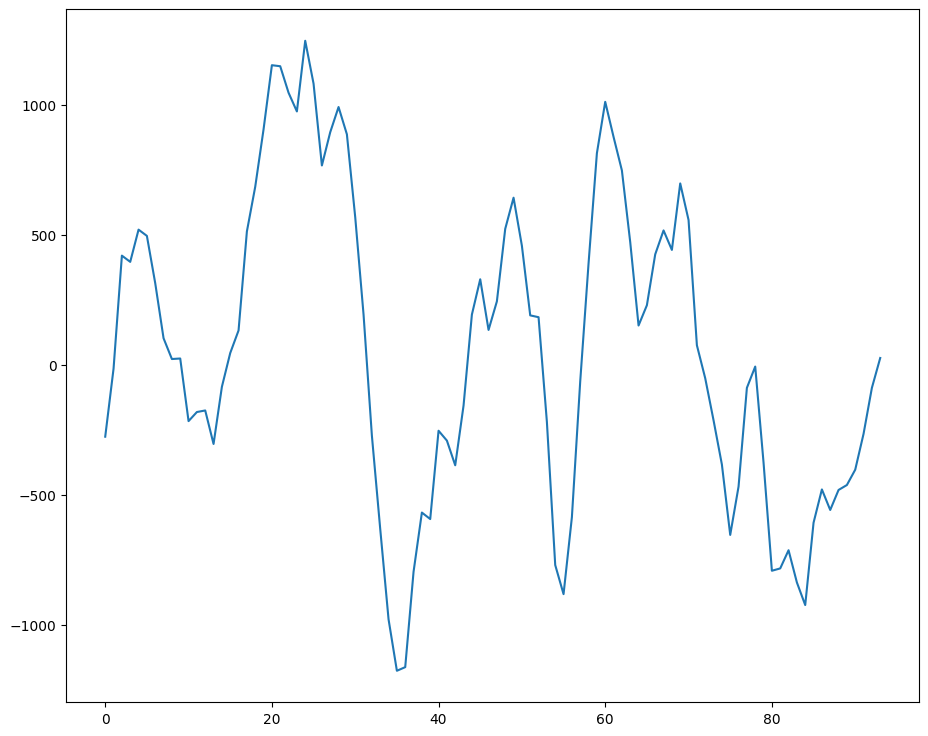

In [115]:
# отрисовываем временной ряд без сезонности
plt.plot(notseason)

Аналогичным образом проведем тест Дики-Фуллера на временном ряде без сезонности

In [116]:
alpha = 0.05
name = "Cпрос без сезона"

ts = notseason

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Cпрос без сезона :
Test Statistic                 -3.763192
p-value                         0.003307
#Lags Used                      9.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Преобразование Бокса-Кокса <a class="anchor" id="boxcox"></a>

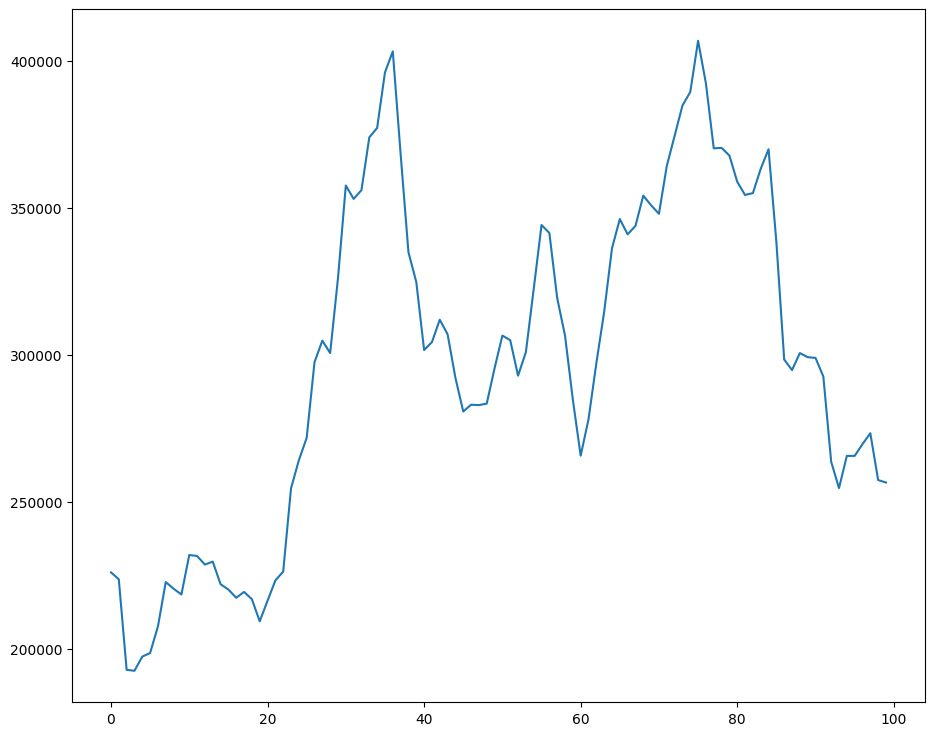

In [117]:
# Преобразование Бокса-Кокса
from scipy.stats import boxcox

# вызываем функцию преобразования, которая выдает преобразованные данные и
# лучший параметр лямбда, который обеспечивает близость к нормальному
# распределению
transformed_data, best_lambda = boxcox(passengers["x"])

# а теперь посмотрим на преобразованные данные
plt.plot(transformed_data)

Попробуем теперь из преобразованного временного ряда удалить тренд и
визуализировать его

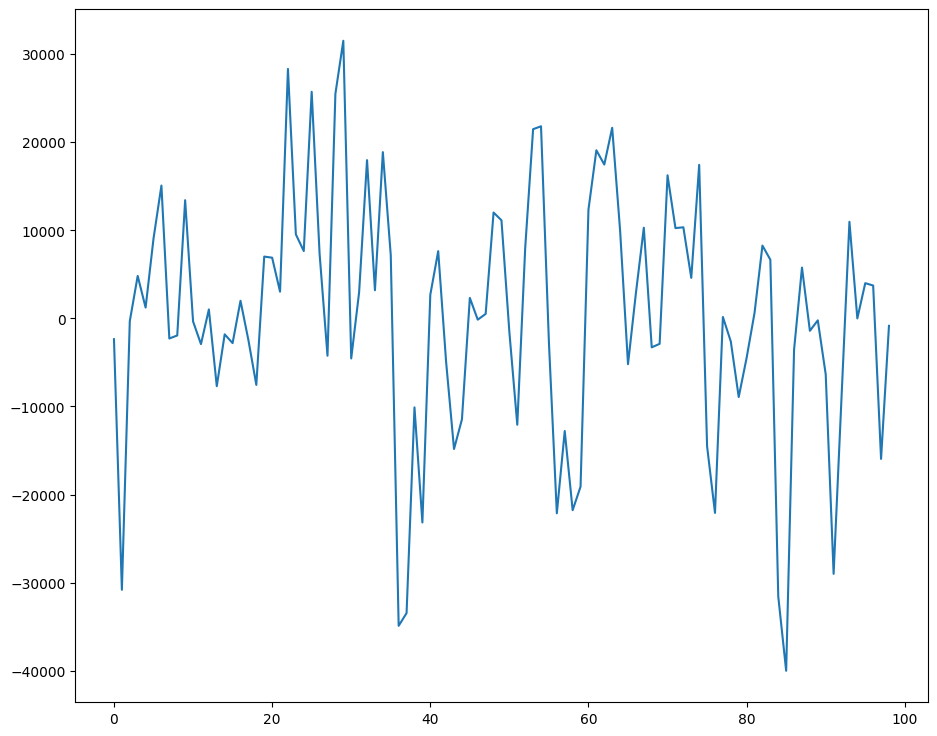

In [118]:
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend)

Удалив тренд из преобразованного Боксом-Коксом ряда, попробуем опять проверить его на стационарность. Что-то изменилось?

In [119]:
alpha = 0.05
name = "Спрос после Кокса-Бокса"

ts = pnottrend

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Спрос после Кокса-Бокса :
Test Statistic                 -3.689141
p-value                         0.004269
#Lags Used                      4.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Модели для предсказания значений временного ряда <a class="anchor" id="predict"></a>

Первой моделью будет модель **AR**, или же autoregression - модель, которая использует связь между наблюдением и некоторым количеством предыдущих наблюдений.​

Сделаем случайный ряд и затем поработаем с ним.

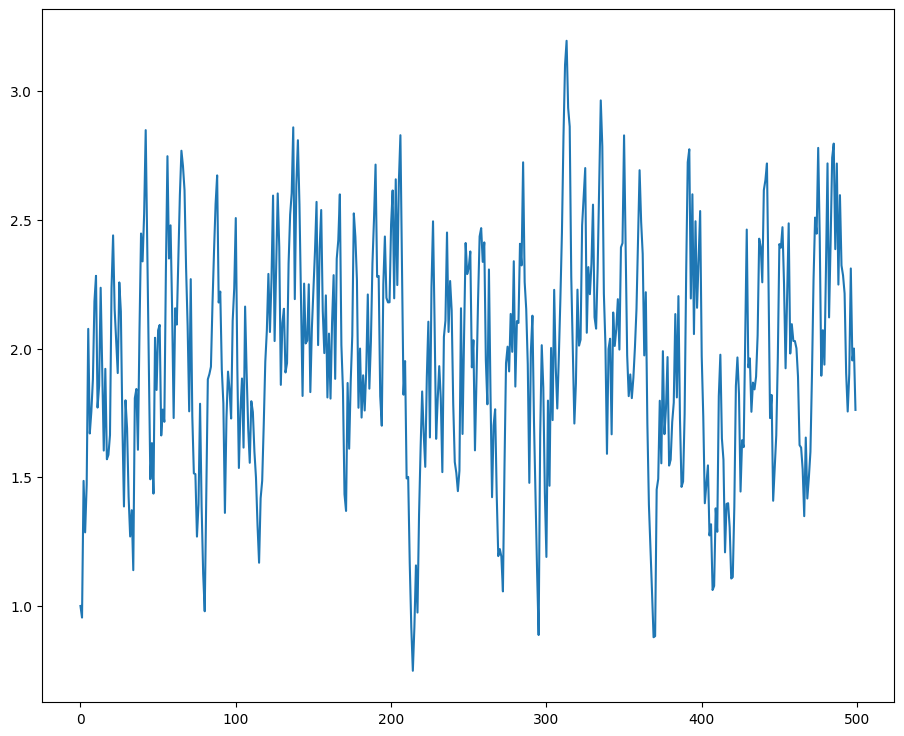

In [120]:
# AR(1)

N = 500

ar1 = [1]

for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())

plt.plot(ar1)

Посмотрим какие у него стандартное отклонение и среднее.

In [121]:
print(f"standart deviation = {np.std(ar1)}\n mean = {np.mean(ar1)}")

standart deviation = 0.4368240370453989
 mean = 1.9725211465581582


А теперь обернем его в датафрейм и посмотрим его обычную и частичную автокорреляцию. Что можно сказать по поводу этого временного ряда, глядя на эти параметры?

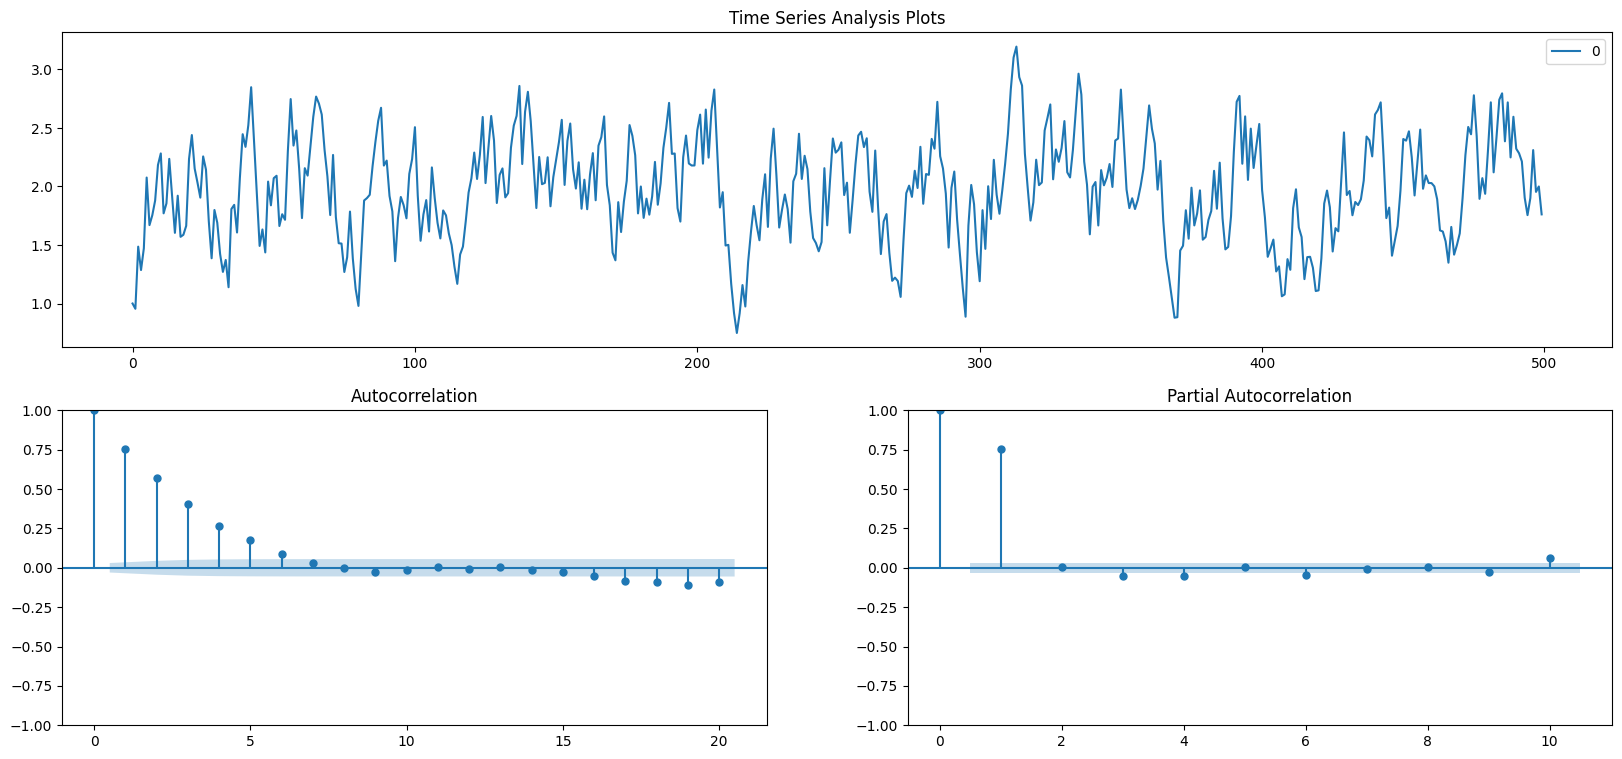

In [122]:
ts = pd.DataFrame(ar1)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

Сделаем ещё один случайный ряд, но уже и с отрицательными значениями коэффициента

standart deviation = 0.4324908938413653
 mean = 0.28446795247455325


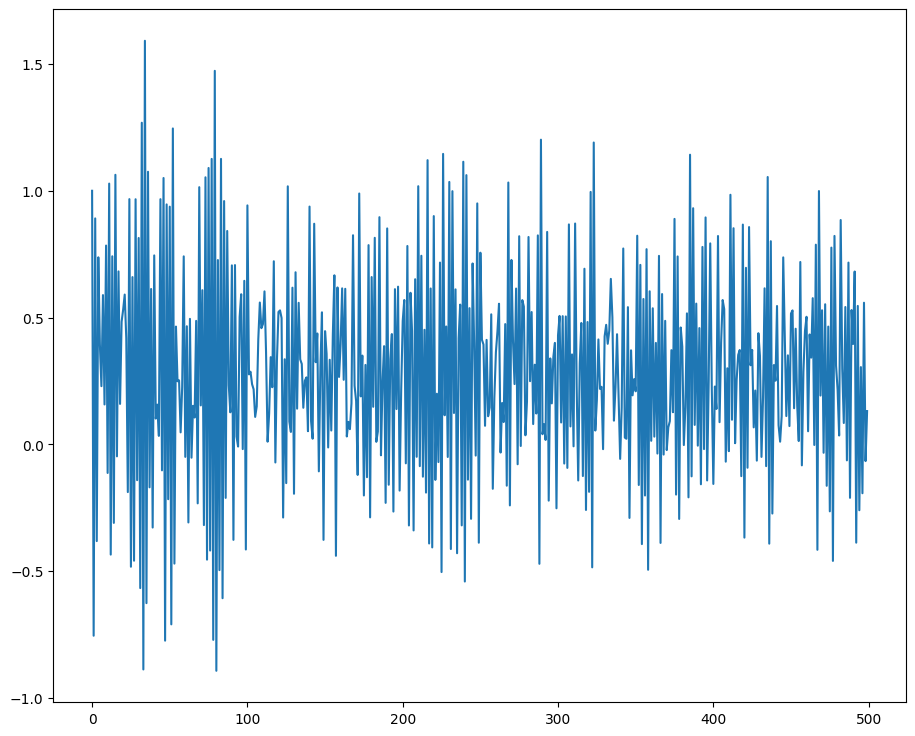

In [123]:
# AR(1)

N = 500

ar2 = [1]

for i in range(1, N):
    ar2.append(- 0.76*ar2[i-1] + np.random.random())

plt.plot(ar2)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

А что можно сказать по поводу этого ряда?

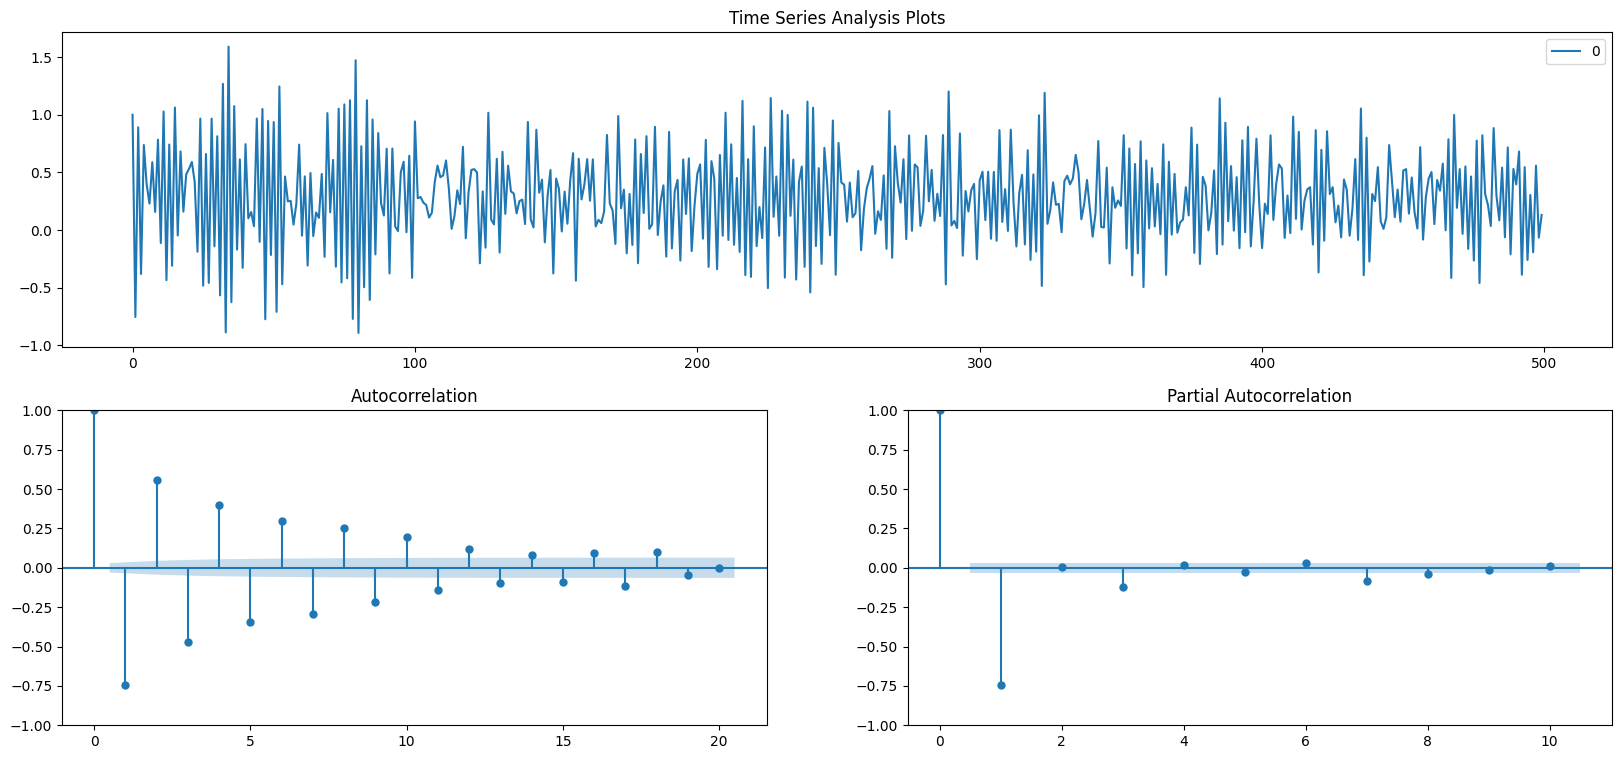

In [124]:
ts = pd.DataFrame(ar2)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

А теперь коэффициент >1

standart deviation = 0.4324908938413653
 mean = 0.28446795247455325


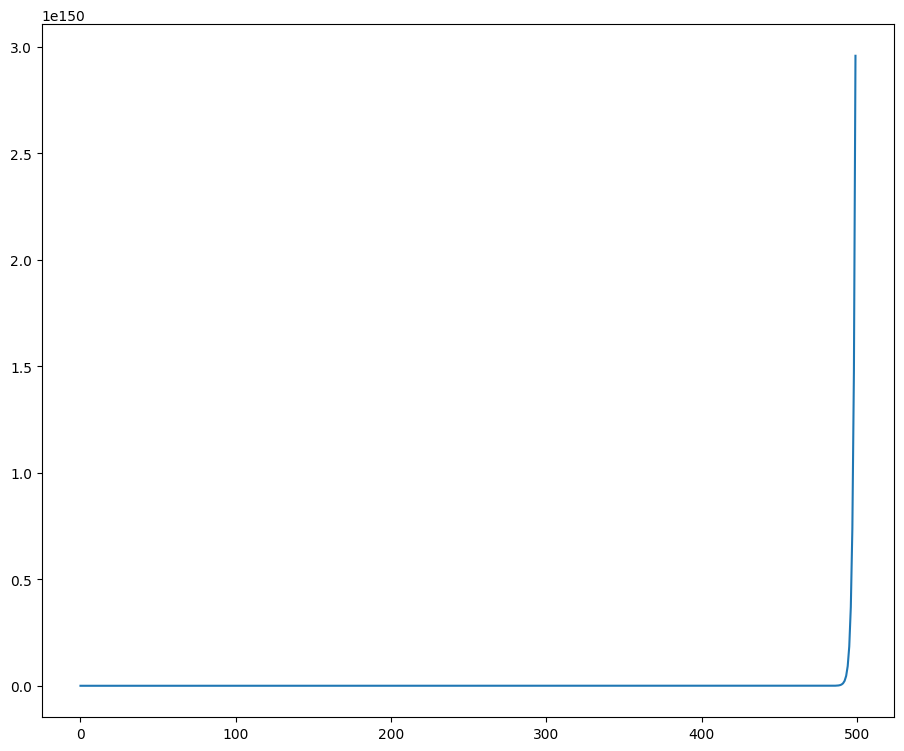

In [125]:
# AR(1)

N = 500

ar3 = [1]

for i in range(1, N):
    ar3.append(2 * ar3[i-1] + np.random.random())

plt.plot(ar3)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

Ладно, пора возвращаться к прогнозированию. Следаем прогноз с помощью AR модели, предварительно поделив выборки на обучающую, валидационную и тестовую.

In [126]:
df = pd.read_csv('Weekly demand for a plastic container Montgomery  Johnson.csv', names=["n","x"], skiprows=1)


df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

Визуализируем поделенные выборки.

* Обучающая выборка - синим цветом
* Валидационная выборка - оранжевым цветом
* Предсказываемая выборка - зеленым цветом

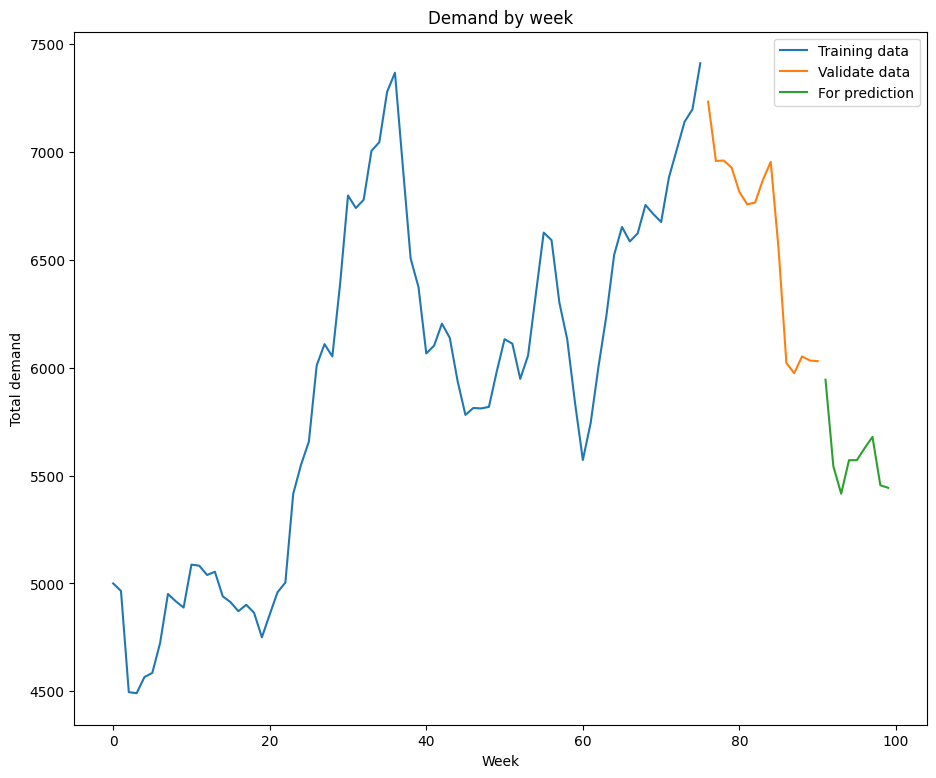

In [127]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Demand by week')
plt.ylabel('Total demand')
plt.xlabel('Week')
plt.show()

In [128]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [129]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(df.t, 3, old_names=False)
# обучаем
res = mod.fit()

# выводим сводку информации об авторегрессионной модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  100
Model:                     AutoReg(3)   Log Likelihood                2887.978
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 03 Nov 2023   AIC                          -5765.956
Time:                        15:09:52   BIC                          -5753.083
Sample:                             3   HQIC                         -5760.751
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   1.92e-15   3.48e+14      0.000       0.667       0.667
t.L1           1.0000   1.89e-15    5.3e+14      0.000       1.000       1.000
t.L2           0.3333    3.4e-17   9.81e+15      0.0

In [130]:
# опять обучаем модель, но на этот раз указываем тип ковариационной оценки
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  100
Model:                     AutoReg(3)   Log Likelihood                2887.978
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 03 Nov 2023   AIC                          -5765.956
Time:                        15:09:52   BIC                          -5753.083
Sample:                             3   HQIC                         -5760.751
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   1.66e-15   4.02e+14      0.000       0.667       0.667
t.L1           1.0000   1.63e-15   6.14e+14      0.000       1.000       1.000
t.L2           0.3333   3.36e-17   9.93e+15      0.0

Продолжаем экспериментировать

In [131]:
sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                  100
Model:                     AutoReg(6)   Log Likelihood                -597.993
Method:               Conditional MLE   S.D. of innovations            140.147
Date:                Fri, 03 Nov 2023   AIC                           1211.986
Time:                        15:09:52   BIC                           1232.333
Sample:                             6   HQIC                          1220.205
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        282.1422    124.135      2.273      0.023      38.842     525.443
x.L1           1.7104      0.100     17.132      0.000       1.515       1.906
x.L2          -1.3503      0.189     -7.131      0.0

Смотрим, что он предсказал

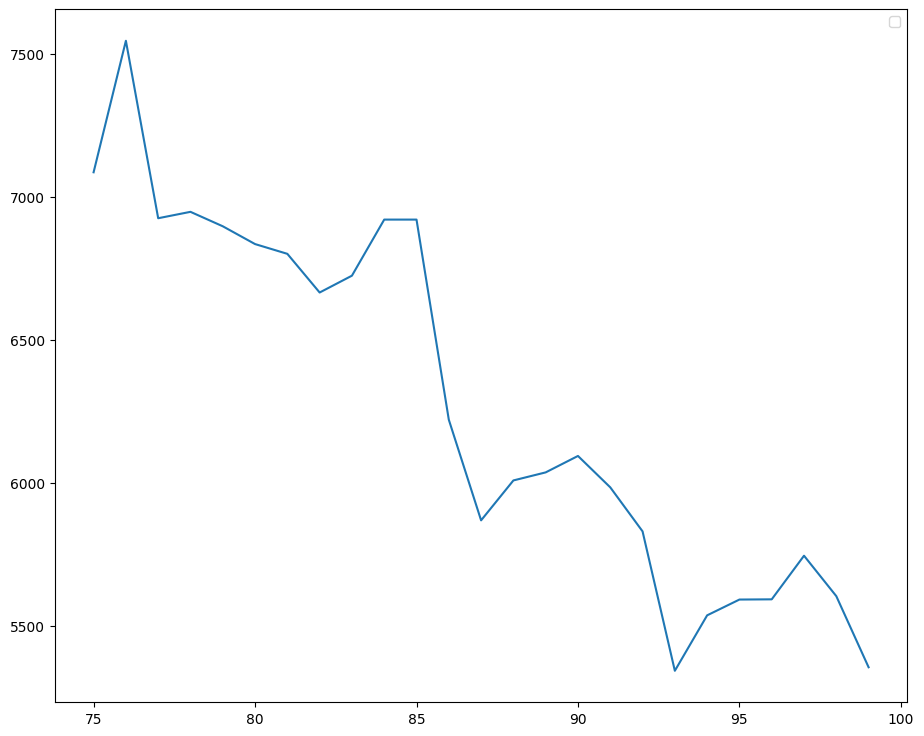

In [132]:
fig = res.plot_predict(train_cutoff)

Формируем предсказанные временные ряды

In [133]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(df.t)-1]), dynamic=False)

Отрисовываем их

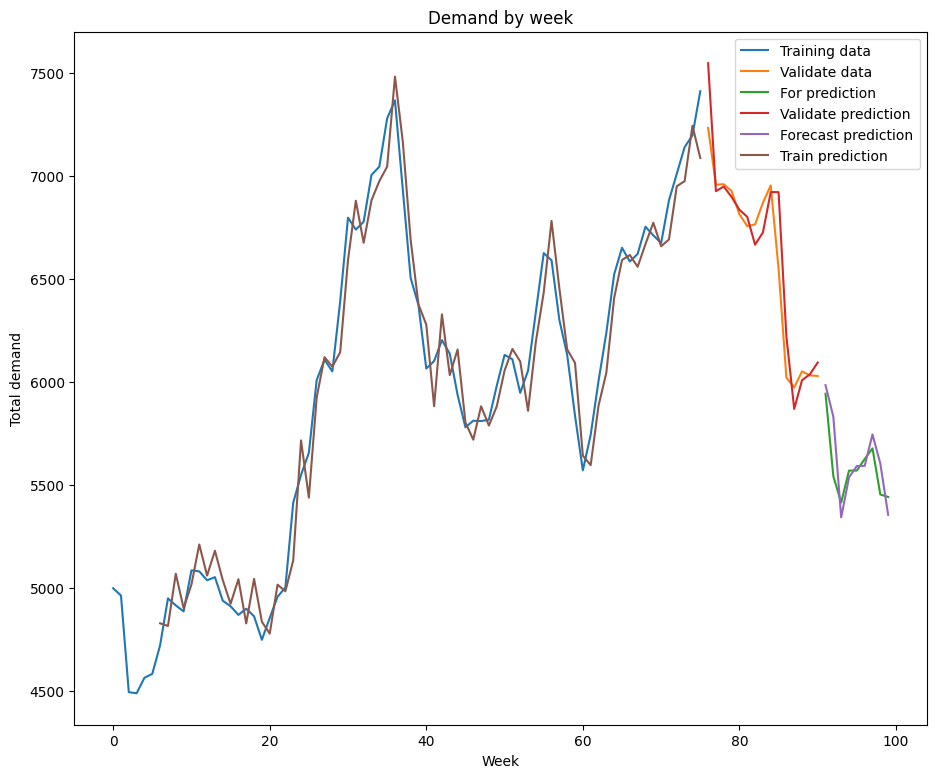

In [134]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Demand by week')
plt.ylabel('Total demand')
plt.xlabel('Week')
plt.show()

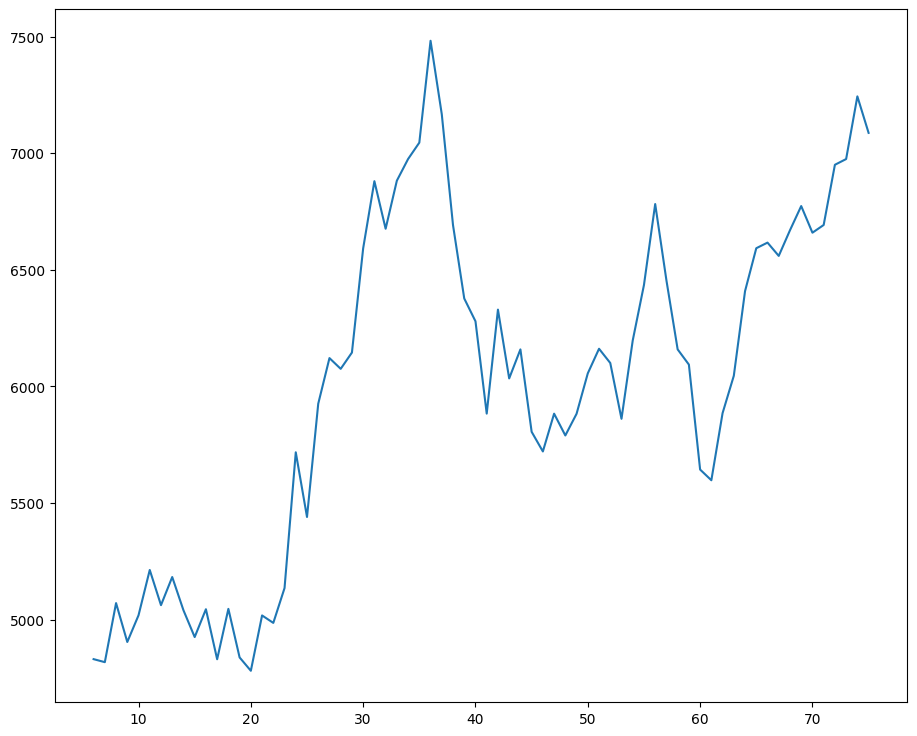

In [135]:
plt.plot(pred)

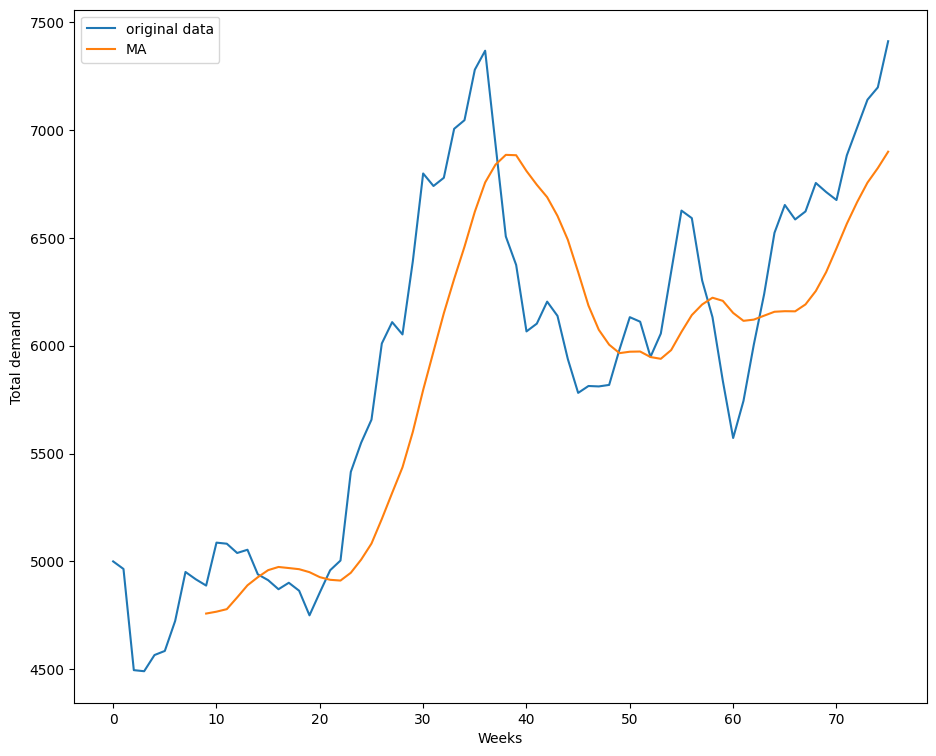

In [136]:
# MA

df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total demand')
plt.xlabel('Weeks')
plt.show()

## Метрики точности прогноза <a class="anchor" id="metrics"></a>

* R2- коэффициент детерминации     ​
* MSE (RMSE) – mean squared error – среднеквадратичная ошибка​
* MAE – mean absolute error – средняя абсолютная ошибка​
* MAPE – mean absolute percentage error – средняя абсолютная ошибка в %​
* SMAPE – symmetric mean absolute percentage error – симметричная средняя абсолютная ошибка в %

Определяем метрики точности прогноза из библиотеки sklearn. Попробуй определить последнюю оставшуюся метрику **SMAPE** самостоятельно.

In [137]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

Вычислим значения ошибок модели AR, опираясь на предсказанные ею значения forecast.

In [138]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))

RMSE: 118.96589973691567
MAPE: 0.01593292208381179
MAE: 88.2590297816692
R2:  0.3853506621528884
